In [8]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, islice
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import csv
import sys
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.sparse as sparse

# First, let's look at head circumference

In [9]:
child_to_headcirc = dict()
with open('../../PhasingFamilies/phenotypes/ihart/AGRE_PhysMeas1.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    head_circ_index = header.index('Maximum_Head_Circumference')
    age_index = header.index('age')
    id_index = header.index('Individual ID')
    
    for pieces in reader:
        c = float(pieces[head_circ_index])
        if c != 0 and c != -1:
            child_to_headcirc[pieces[id_index]] = c
    
    

In [10]:
ped_file = '../../DATA/ihart.ms2/ihart.ped'

# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
mother_to_children = defaultdict(set)
father_to_children = defaultdict(set)
child_to_mother = dict()
child_to_father = dict()

with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            
            if 'LCL' not in child_id and f_id != '0' and m_id != '0':
                mother_to_children[m_id].add(child_id)
                father_to_children[f_id].add(child_id)
                child_to_mother[child_id] = m_id
                child_to_father[child_id] = f_id


print('ped loaded')


ped loaded


In [37]:
sibpairs = []

# pull identicals
with open('../../PhasingFamilies/phased_ihart.ms2_quads_del/identicals.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[2] == 'identical':
            sibs = [pieces[0], pieces[1]]
            random.shuffle(sibs)
            if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
                sibpairs.append((sibs, 'identical'))
            
# pull full sibs and mat half sibs
for mother, children in mother_to_children.items():
    for sib1, sib2 in combinations(children, r=2):
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
            if child_to_father[sib1] == child_to_father[sib2]:
                sibpairs.append((sibs, 'full'))
            else:
                sibpairs.append((sibs, 'mat half'))
            
# pull pat half sibs
for father, children in father_to_children.items():
    for sib1, sib2 in combinations(children, r=2):
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
            if child_to_mother[sib1] != child_to_mother[sib2]:
                sibpairs.append((sibs, 'pat half'))
                



In [38]:
# you need to interrupt this after a few seconds, because it just keeps going - no need to have all pairs

children = list(set(sum([list(x) for x in mother_to_children.values()], [])))
random.shuffle(children)

unrelated_sibpairs = list(combinations(children, r=2))
random.shuffle(unrelated_sibpairs)

for sib1, sib2 in unrelated_sibpairs[:1000]:
    if child_to_father[sib1] != child_to_father[sib2] and child_to_mother[sib1] != child_to_mother[sib2]:
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
            sibpairs.append((sibs, 'unrelated'))

In [39]:
circ = np.array([child_to_headcirc[sibpair[0][0]]-child_to_headcirc[sibpair[0][1]] for sibpair in sibpairs])
is_identical = np.array([sibpair[1]=='identical' for sibpair in sibpairs])
is_full = np.array([sibpair[1]=='full' for sibpair in sibpairs])
is_half_mat = np.array([sibpair[1]=='mat half' for sibpair in sibpairs])
is_half_pat = np.array([sibpair[1]=='pat half' for sibpair in sibpairs])
is_unrelated = np.array([sibpair[1]=='unrelated' for sibpair in sibpairs])
print(np.sum(is_identical), np.sum(is_full), np.sum(is_half_mat|is_half_pat), np.sum(is_unrelated))

55 1391 101 390


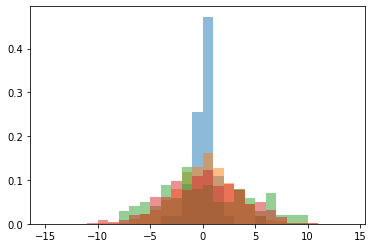

In [40]:
plt.hist(circ[is_identical], bins=np.arange(-15, 15), alpha=0.5, density=True)
plt.hist(circ[is_full], bins=np.arange(-15, 15), alpha=0.5, density=True)
plt.hist(circ[is_half_mat | is_half_pat], bins=np.arange(-15, 15), alpha=0.5, density=True)
plt.hist(circ[is_unrelated], bins=np.arange(-15, 15), alpha=0.5, density=True)

plt.show()

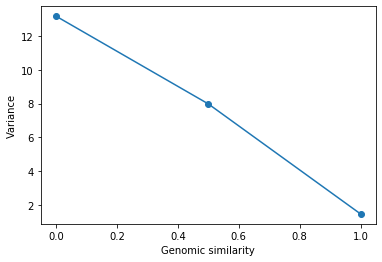

-11.671480223971832 13.374117393889588


In [41]:
plt.plot([0, 0.5, 1], [np.var(circ[is_unrelated]), np.var(circ[is_full]), np.var(circ[is_identical])], marker='o')
plt.xlabel('Genomic similarity')
plt.ylabel('Variance')
plt.show()

m, b = np.polyfit([0, 0.5, 1], 
                  [np.var(circ[is_unrelated]), np.var(circ[is_full]), np.var(circ[is_identical])], 
                  1)
print(m, b)

In [42]:
# we conclude that var is linear in genomic similarity

# Now let's expand to include more detailed genomic similarity
## We also switch to using  SPARK rather than iHART

In [106]:
#dataset = 'recomb_spark'
#ped_file = '../../DATA/spark/sparkfam.ped.quads.ped'

dataset = 'recomb_ihart.ms2'
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

In [107]:
with open('../../PhasingFamilies/%s/sibpairs.json' % dataset, 'r') as f:
	sibpairs = json.load(f)
    
# These lines include identical sibpairs into the analysis

with open('../../PhasingFamilies/%s/identical_sibpairs.json' % dataset, 'r') as f:
	sibpairs.extend(json.load(f))
    
sibpairs = [x for x in sibpairs if ('LCL' not in x['sibling1']) and ('LCL' not in x['sibling2'])]
    
print('Overall')
print('families', len(set([x['family'].split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
num_sibpairs = len(sibpairs)

Overall
families 845
sibpairs 2011


In [108]:
#sample_to_affected = dict()
##with open('../../PhasingFamilies/phenotypes/spark_v5/spark_v5-scq-prep.csv', 'r') as f:
#    reader = csv.reader(f)
#    for pieces in reader:
#        phen = pieces[13:53]
#        sample_to_affected[pieces[2]] = phen

In [109]:
sample_to_affected = child_to_headcirc

In [110]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_to_sex = dict()

with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if sex=='1' or sex=='2':
                child_to_sex[child_id] = sex


print('ped loaded', len(child_to_sex))


ped loaded 2635


In [111]:
sibpairs = [x for x in sibpairs if (x['sibling1'] in sample_to_affected) and (x['sibling2'] in sample_to_affected) and (x['sibling1'] in child_to_sex) and (x['sibling2'] in child_to_sex)]
for sibpair in sibpairs:
    if random.randint(1, 2)==1:
        sibpair['sibling1'], sibpair['sibling2'] = sibpair['sibling2'], sibpair['sibling1']
print(len(sibpairs))


1200


In [112]:
is_mm = np.array([child_to_sex[sibpair['sibling1']]=='1' and child_to_sex[sibpair['sibling2']]=='1' for sibpair in sibpairs])
is_mf = np.array([child_to_sex[sibpair['sibling1']]=='1' and child_to_sex[sibpair['sibling2']]=='2' for sibpair in sibpairs])
is_fm = np.array([child_to_sex[sibpair['sibling1']]=='2' and child_to_sex[sibpair['sibling2']]=='1' for sibpair in sibpairs])
is_ff = np.array([child_to_sex[sibpair['sibling1']]=='2' and child_to_sex[sibpair['sibling2']]=='2' for sibpair in sibpairs])

assert np.all(is_mm | is_mf | is_fm | is_ff)
assert np.all(is_mm.astype(int) + is_mf.astype(int) + is_fm.astype(int) + is_ff.astype(int) == 1)

print(np.sum(is_mm), np.sum(is_mf), np.sum(is_fm), np.sum(is_ff))

590 246 229 135


In [113]:
X = np.array([[sibpair['maternal_ibd'], sibpair['paternal_ibd']] for sibpair in sibpairs])

#P = np.array([[-1 if ((x not in {'1.0', '0.0'}) or (y not in {'1.0', '0.0'})) else int(x!=y) for x, y in zip(sample_to_affected[sibpair['sibling1']], sample_to_affected[sibpair['sibling2']])] for sibpair in sibpairs])

P = np.array([sample_to_affected[sibpair['sibling1']]-sample_to_affected[sibpair['sibling2']] for sibpair in sibpairs])

print(X.shape, P.shape)


(1200, 2) (1200,)


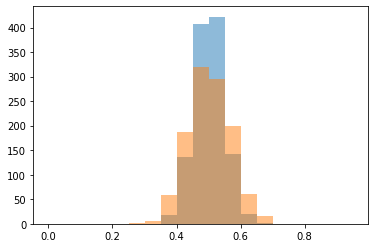

maternal 0.5226233847470284 0.012437404944197502
paternal 0.5235476635069236 0.014460564017782748


In [114]:
plt.hist(X[:, 0], alpha=0.5, bins=np.arange(0, 1, 0.05))
plt.hist(X[:, 1], alpha=0.5, bins=np.arange(0, 1, 0.05))
plt.show()

print('maternal', np.mean(X[:, 0]), np.var(X[:, 0]))
print('paternal', np.mean(X[:, 1]), np.var(X[:, 1]))

In [74]:
# Paternal similarity has a higher variance than maternal similarity
# Both have means near 0.5 as expected

In [ ]:
# Below we do MLE
# We assume Y is a random variable in {-1, 0, 1}
# We know that the distribution of Y must be symmetric (by symmetry of sibpairs)
# From head circumference, we know we want to model var(Y) = a*g_mat + b*g_pat + e
# where a captures the variance component driven by maternal genomic similarity, 
# b captures the variance component driven by paternal genomic similarity
# and e is all the rest of the variance
# we expect a, b <= 0 and e >= 0

# Let 
# p_1 = P[Y=-1]
# p_2 = P[Y=0]
# p_3 = P[Y=1]

# by symmetry p_1 = p_3

# by definition, since E[Y] = 0,
# var(Y) = p_1(-1)^2 + p_2(0)^2 + p_3(1)^2
#        = 2p_1
# p_1 = var(Y)/2
# p_2 = 1 - var(Y)
# p_3 = var(Y)/2

# putting this all together, the log likelihood of our data under this model is
# \sum_{Y_i in {-1, 1}} \log(a*g_mat^i + b*g_pat^i + e)/2
# + \sum_{Y_i = 0} \log(1- (a*g_mat^i + b*g_pat^i + e))

# Luckily for us, the above is concave, so we solve with cvxpy
# Then we do a bunch of permutation tests to figure out if anything is meaningful

In [ ]:
def solve(G, p):
    a = cp.Variable()
    b = cp.Variable()
    e = cp.Variable()

    v = a*(1-G[:, 0]) + b*(1-G[:, 1]) + e
    prob = cp.Problem(cp.Maximize(cp.sum(cp.log(v[p==1]/2)) + cp.sum(cp.log(1-v[p==0]))),
                     [a>=0, b>=0, e>=0])
    prob.solve(solver='ECOS')
    
    return np.array([a.value, b.value, e.value])

var_components = np.zeros((40, 3))
var_baseline = np.zeros((40, 3, 5000))
indices = np.arange(0, X.shape[0])

for phen_index in range(40):
    var_components[phen_index, :] = solve(X, P[:, phen_index])

for j in range(5000):
    print(j, end=' ')
    
    np.random.shuffle(indices)
    Z = X[indices, :]
    
    for phen_index in range(40):    
        var_baseline[phen_index, :, j] = solve(Z, P[:, phen_index])

In [ ]:
aut_response = ['0.0', '0.0', '1.0', '1.0', '1.0',
                '1.0', '1.0', '1.0', '0.0', '1.0',
                '1.0', '1.0', '1.0', '1.0', '1.0',
                '1.0', '1.0', '1.0', '0.0', '0.0',
                '0.0', '0.0', '0.0', '0.0', '0.0',
                '0.0', '0.0', '0.0', '0.0', '0.0',
                '0.0', '0.0', '0.0', '0.0', '0.0',
                '0.0', '0.0', '0.0', '0.0', '0.0']

def pull_phenotype(indices):
    phen = np.zeros((len(sibpairs),), dtype=int)
    has_missing = np.zeros((len(sibpairs),), dtype=bool)
    for i, sibpair in enumerate(sibpairs):
        for j in indices:
            sib1_phen, sib2_phen = sample_to_affected[sibpair['sibling1']][j], sample_to_affected[sibpair['sibling2']][j]
            if (sib1_phen in {'1.0', '0.0'}) and (sib2_phen in {'1.0', '0.0'}):
                phen[i] += (int(sib1_phen==aut_response[j]) - int(sib2_phen==aut_response[j]))
            else:
                has_missing[i] = True
    return phen, has_missing

In [ ]:
bootstrap_pvalues = np.ones((40, 3))
for i in range(40):
    for j in range(3):
        bootstrap_pvalues[i, j] = np.sum(var_components[i, j] <= var_baseline[i, j, :1000])/1000


In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.violinplot(var_baseline[:, 0, :].T, showmedians=True)
plt.scatter(np.arange(1, 41), var_components[:, 0])

plt.subplot(2, 1, 2)
plt.violinplot(var_baseline[:, 1, :].T, showmedians=True)
plt.scatter(np.arange(1, 41), var_components[:, 1])

plt.show()

In [ ]:
for j in range(2):
    plt.plot(np.clip(-np.log10(bootstrap_pvalues[:, j]), None, 3))
plt.axhline(-np.log10(0.05/40))
plt.show()

for i in range(40):
    if np.any(bootstrap_pvalues[i, :]<0.01):
        print('SCQ', i+1, bootstrap_pvalues[i, :], ['%0.2f' % x for x in var_components[i, :]], 
              ['%0.2f' % x for x in var_components[i, :]])
        print(var_components[i, :]/np.sum(var_components[i, :]))
        
        

In [ ]:
phen_index = 2
plt.hist(X[P[:, phen_index]==0, 1], alpha=0.5, bins=np.arange(0.2, 1.2, 0.02), density=True)
plt.hist(X[P[:, phen_index]==1, 1], alpha=0.5, bins=np.arange(0.2, 1.2, 0.02), density=True)
plt.show()

# subscore

In [115]:
print(np.min(P), np.max(P))

-10.5 10.5


In [138]:
y = P
k = 12

na, nb, nc = (20, 20, 20)
a = np.linspace(0.1, 2, na)
b = np.linspace(0.1, 2, nb)
c = np.linspace(0.1, 10, nc)
x = np.arange(-k, k+1)

av, bv, cv = np.meshgrid(a, b, c, indexing='ij')

print(av.shape, bv.shape, cv.shape)

v = av[:, :, :, np.newaxis]*X[:, 0].T + bv[:, :, :, np.newaxis]*X[:, 1].T + cv[:, :, :, np.newaxis]*np.ones((1, X.shape[0]))

norm = np.log(np.sum(np.exp((-0.5/v[:, :, :, :, np.newaxis])*((x**2).T)), axis=4))

ll = np.sum((-0.5*(y**2)/v) - norm, axis=3)

print(ll.shape)

(20, 20, 20) (20, 20, 20) (20, 20, 20)
(20, 20, 20)


In [139]:
indices = np.where(ll==np.max(ll))
print(indices, a[indices[0]], b[indices[1]], c[indices[2]])

(array([0]), array([0]), array([15])) [0.1] [0.1] [7.91578947]


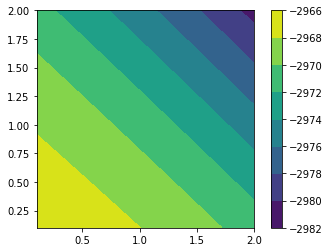

In [141]:
plt.contourf(a, b, ll[:, :, 15])
plt.axis('scaled')
plt.colorbar()
plt.show()

10.186338605619147 8.719367320261437
8.537130710115967 8.148883764648437
7.60625728588756 9.099024807112855
7.045853695130314 6.939119742057075


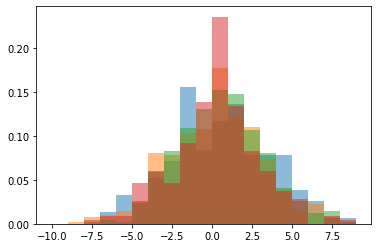

In [147]:
plt.hist(y[X[:, 0]<0.45], bins=np.arange(-10, 10), alpha=0.5, density=True)
plt.hist(y[(X[:, 0]>=0.45) & (X[:, 0]<0.5)], bins=np.arange(-10, 10), alpha=0.5, density=True)
plt.hist(y[(X[:, 0]>=0.5) & (X[:, 0]<0.55)], bins=np.arange(-10, 10), alpha=0.5, density=True)
plt.hist(y[X[:, 0]>=0.55], bins=np.arange(-10, 10), alpha=0.5, density=True)

print(np.var(y[X[:, 0]<0.45]), np.var(y[X[:, 1]<0.45]))
print(np.var(y[(X[:, 0]>=0.45) & (X[:, 0]<0.5)]), np.var(y[(X[:, 1]>=0.45) & (X[:, 1]<0.5)]))
print(np.var(y[(X[:, 0]>=0.5) & (X[:, 0]<0.55)]), np.var(y[(X[:, 1]>=0.5) & (X[:, 1]<0.55)]))
print(np.var(y[X[:, 0]>=0.55]), np.var(y[X[:, 1]>=0.55]))

plt.show()

(-0.04042107999942966, 0.17111796405754934)
(0.005560416925170207, 0.8507237238050084)


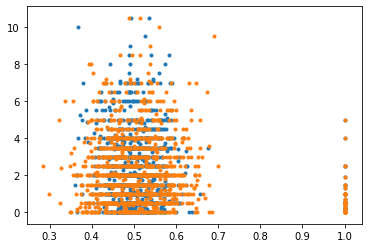

In [129]:
plt.scatter(X[:, 0], np.abs(y), marker='.')
plt.scatter(X[:, 1], np.abs(y), marker='.')
print(stats.pearsonr(X[X[:, 0]<0.9, 0], np.abs(y[X[:, 0]<0.9])))
print(stats.pearsonr(X[X[:, 1]<0.9, 1], np.abs(y[X[:, 1]<0.9])))

In [ ]:
# Let 
# p_1 = P[Y=-2]
# p_2 = P[Y=-1]
# p_3 = P[Y=0]
# p_4 = P[Y=1]
# p_5 = P[Y=2]

# by symmetry p_1 = p_5, p_2 = p_4

# because it's a probability distribution we know p_1 + p_2 + p_3 + p_4 + p_5 = 1

# we also enforce a linear relationship between p_1, p_2, p_3 so
# 

# by definition, since E[Y] = 0,
# var(Y) = p_1(-2)^2 + p_2(-1)^2 + p_3(0)^2 + p_2(1)^2 + p_1(2)^2
#        = 8p_1 + 2p_2
# p_1 = var(Y)/2
# p_2 = 1 - var(Y)
# p_3 = var(Y)/2

# putting this all together, the log likelihood of our data under this model is
# \sum_{Y_i in {-1, 1}} \log(a*g_mat^i + b*g_pat^i + e)/2
# + \sum_{Y_i = 0} \log(1- (a*g_mat^i + b*g_pat^i + e))

# Luckily for us, the above is concave, so we solve with cvxpy
# Then we do a bunch of permutation tests to figure out if anything is meaningful

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(var_components[:, 0], var_components[:, 1])

plt.subplot(1, 2, 2)
plt.scatter(var_components[:, 2], var_components[:, 0])
plt.scatter(var_components[:, 2], var_components[:, 1])

In [ ]:
plt.scatter(var_components[:, 0], np.clip(-np.log10(bootstrap_pvalues[:, 0]), None, 3))
plt.scatter(var_components[:, 1], np.clip(-np.log10(bootstrap_pvalues[:, 1]), None, 3))
plt.scatter(var_components[:, 2], np.clip(-np.log10(bootstrap_pvalues[:, 2]), None, 3))